In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import math

from datetime import datetime

## Data

### Trading Dates

First, just a list of trading dates to backtest

In [79]:
TRADING_DATES_FILE_PATH = 'trading_dates.csv'
def load_trading_dates(): 
  return pd.to_datetime(
    pd.read_csv(TRADING_DATES_FILE_PATH, header=None)[0],
  )

In [82]:
TRADING_DATES = load_trading_dates()
TRADING_DATES

0     2000-01-21
1     2000-02-18
2     2000-03-17
3     2000-04-20
4     2000-05-19
         ...    
229   2019-02-15
230   2019-03-15
231   2019-04-18
232   2019-05-17
233   2019-06-21
Name: 0, Length: 234, dtype: datetime64[ns]

### SPX Index Data



In [224]:
SPX_PRICES_FILE_PATH = 'spx_index_prices.csv'
STOCK_PRICES_DATE_COL = 'Date'
STOCK_PRICES_HIGH_COL = 'High'
STOCK_PRICES_LOW_COL = 'Low'
STOCK_PRICES_AVG_COL = 'Avg'

def load_spx_prices():
  spx_prices = pd.read_csv(SPX_PRICES_FILE_PATH)
  spx_prices[STOCK_PRICES_DATE_COL] = pd.to_datetime(spx_prices[STOCK_PRICES_DATE_COL])
  spx_prices[STOCK_PRICES_AVG_COL] = ((spx_prices[STOCK_PRICES_HIGH_COL] + spx_prices[STOCK_PRICES_LOW_COL]) / 2)
  
  return spx_prices

In [88]:
STOCK_PRICES = load_spx_prices()
STOCK_PRICES

,Date,Open,High,Low,Close,Adj Close,Volume,Avg
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1462.234985
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1427.320007
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1400.765015
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.779968
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1422.459961
...,...,...,...,...,...,...,...,...
5081,2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7781540000,2447.359985
5082,2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8358500000,2477.424926
5083,2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8755780000,2417.300049
5084,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2401.434936


### SPX Options Data

Now, a whole 600MBs of options data

In [91]:
SPX_OPTION_PRICES_FILE_PATH = 'spx_option_prices.csv'
OPTION_PRICES_DATE_COL = 'date'
OPTION_PRICES_EXPIRATION_COL = 'exdate'
OPTION_PRICES_MATURITY_COL = 'maturity'
OPTION_PRICES_STRIKE_COL = 'strike_price'
OPTION_PRICES_BID_COL = 'best_bid'
OPTION_PRICES_OFFER_COL = 'best_offer'
OPTION_PRICES_SPREAD_COL = 'spread'
OPTION_PRICES_AVG_COL = 'avg'
OPTION_PRICES_DATE_FMT = '%Y%m%d'

def load_spx_option_prices():
  option_prices = pd.read_csv(SPX_OPTION_PRICES_FILE_PATH);
  option_prices[OPTION_PRICES_DATE_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_DATE_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_EXPIRATION_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_EXPIRATION_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_STRIKE_COL] = option_prices[OPTION_PRICES_STRIKE_COL].div(1000)
  option_prices[OPTION_PRICES_MATURITY_COL] = (
    option_prices[OPTION_PRICES_EXPIRATION_COL] - 
    option_prices[OPTION_PRICES_DATE_COL]
  ).dt.days
  option_prices[OPTION_PRICES_SPREAD_COL] = (
    option_prices[OPTION_PRICES_OFFER_COL] - 
    option_prices[OPTION_PRICES_BID_COL]
  )
  option_prices[OPTION_PRICES_AVG_COL] = (
    (
      option_prices[OPTION_PRICES_OFFER_COL] +
      option_prices[OPTION_PRICES_BID_COL]
    ) / 2
  )

  return option_prices

In [94]:
OPTION_PRICES = load_spx_option_prices()
OPTION_PRICES

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,vega,theta,optionid,forward_price,index_flag,issuer,exercise_style,maturity,spread,avg
0,108105,2000-01-03,2000-03-18,19991229.0,P,1410.0,36.750,38.750,0,1,...,235.99500,-119.41110,10120210,1470.521157,1,CBOE S&P 500 INDEX,E,75,2.0,37.750
1,108105,2000-01-03,2000-01-22,19991223.0,P,1505.0,55.250,57.250,0,50,...,100.89450,-172.62950,10000760,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,56.250
2,108105,2000-01-03,2000-06-17,20000103.0,P,1350.0,40.750,42.750,290,14570,...,311.57080,-66.86736,10016917,1490.761534,1,CBOE S&P 500 INDEX,E,166,2.0,41.750
3,108105,2000-01-03,2000-01-22,20000103.0,P,1500.0,51.625,53.625,57,505,...,105.71350,-186.79210,10149633,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,52.625
4,108105,2000-01-03,2000-01-22,NaN,P,1540.0,84.875,86.875,0,0,...,68.56206,-96.37443,10056576,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,85.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462523,108105,2019-06-28,2020-06-30,NaN,P,3800.0,824.100,848.000,0,0,...,NaN,NaN,129500433,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,836.050
8462524,108105,2019-06-28,2020-06-30,NaN,P,3900.0,921.200,945.200,0,0,...,NaN,NaN,129500434,2942.162769,1,CBOE S&P 500 INDEX,E,368,24.0,933.200
8462525,108105,2019-06-28,2020-06-30,NaN,P,4000.0,1018.700,1042.500,0,0,...,NaN,NaN,129500435,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.8,1030.600
8462526,108105,2019-06-28,2020-06-30,NaN,P,4100.0,1116.100,1140.000,0,0,...,NaN,NaN,129500436,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,1128.050


## Data Model

Now that we have some data. Let's create data structures for our trading.

## Portfolio


Next, let's create a dataframe to keep track of our portfolio every trading day. We can use this to measure our performance down the road. 

In [97]:
PORTFOLIO_DATE = 'date'
PORTFOLIO_CASH = 'cash'
PORTFOLIO_STOCK_QUANTITY = 'stock_quantity'
PORTFOLIO_OPTION_QUANTITY = 'option_quantity'
PORTFOLIO_OPTION_STRIKE = 'option_strike'
PORTFOLIO_OPTION_EXPIRATION = 'option_expiration_date'

def build_portfolio_log(): 
  portfolio_log = pd.DataFrame(
    columns=[
        PORTFOLIO_DATE,
        PORTFOLIO_CASH,
        PORTFOLIO_STOCK_QUANTITY,
        PORTFOLIO_OPTION_QUANTITY,
        PORTFOLIO_OPTION_STRIKE,
        PORTFOLIO_OPTION_EXPIRATION
    ]
  )
  portfolio_log.index = portfolio_log[PORTFOLIO_DATE]

  return portfolio_log

In [100]:
ex_portfolio_log = build_portfolio_log()
ex_portfolio_log

,date,cash,stock_quantity,option_quantity,option_strike,option_expiration_date
date,,,,,,


After that, let's create a helper function to create a row

In [103]:
def build_portfolio_row(
  date, 
  cash, 
  stock_quantity, 
  option_quantity,
  option_strike,
  option_expiration):
  return pd.Series({
    PORTFOLIO_DATE: date,
    PORTFOLIO_CASH: cash,
    PORTFOLIO_STOCK_QUANTITY: stock_quantity,
    PORTFOLIO_OPTION_QUANTITY: option_quantity,
    PORTFOLIO_OPTION_STRIKE: option_strike,
    PORTFOLIO_OPTION_EXPIRATION: option_expiration,
  })

In [106]:
ex_portfolio_row = build_portfolio_row(
  date=datetime(2000, 1, 3),
  cash=2000,
  stock_quantity=100,
  option_quantity=1000,
  option_strike=1100,
  option_expiration=datetime(2000, 2, 19))

ex_portfolio_row

date                      2000-01-03 00:00:00
cash                                     2000
stock_quantity                            100
option_quantity                          1000
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object

## Goal

Next, let's create a goal data structure. This can encode our preferences for how we want to allocate stock, and what kind of options we want to buy: at what otm range and at what expiration.


In [109]:
GOAL_STOCK_ALLOC = 'stock_alloc'
GOAL_OTM_RANGE = 'otm_range'
GOAL_MATURITY_RANGE = 'maturity_range'

def build_goal(stock_alloc, otm_range, maturity_range):
  return {
    GOAL_STOCK_ALLOC: stock_alloc, 
    GOAL_OTM_RANGE: otm_range, 
    GOAL_MATURITY_RANGE: maturity_range
  }

So if we wanted to allocated 99.5% SPY, and buy options that are within 2-3 month expiration, and 0.3 - 0.5% OTM, we would write

In [112]:
build_goal(stock_alloc=0.995, otm_range=(0.3, 0.5), maturity_range=(60, 90))

{'stock_alloc': 0.995, 'otm_range': (0.3, 0.5), 'maturity_range': (60, 90)}

## Liquidation

In order for us to figure out how much money we have available, let's create some functions to help us liquidate

### SPX

For a given a portfolio row, let's liquidate a requested quantity for the price at that date

In [115]:
def get_stock_col(date, col):
  stock_price_rows = STOCK_PRICES[STOCK_PRICES[STOCK_PRICES_DATE_COL] == date]
  if (stock_price_rows.shape[0] != 1):
    raise SystemExit("Uh oh, expected to find one stock price")

  return stock_price_rows.iloc[0][col]

def get_stock_price(date):
  return get_stock_col(date, STOCK_PRICES_AVG_COL)

def get_stock_value(quantity, date):
  return quantity * get_stock_price(date)

def liquidate_stock(sell_quantity, portfolio_row):
  owned_quantity = portfolio_row[PORTFOLIO_STOCK_QUANTITY] or 0
  if sell_quantity > owned_quantity:
    raise SystemExist(
      "Sell Quantity = {} cannot be greater then Owned Quantity = {}"
        .format(sell_quantity, owned_quantity)
    )
  
  new_portfolio = portfolio_row.copy()
  new_portfolio[PORTFOLIO_STOCK_QUANTITY] = owned_quantity - sell_quantity
  new_portfolio[PORTFOLIO_CASH] += get_stock_value(sell_quantity, portfolio_row[PORTFOLIO_DATE])

  return new_portfolio

In [118]:
liquidate_stock(ex_portfolio_row[PORTFOLIO_STOCK_QUANTITY], ex_portfolio_row)

date                      2000-01-03 00:00:00
cash                                   148223
stock_quantity                              0
option_quantity                          1000
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object

### Option

For an option order, we search through the database, to find the option that has the same date, expiration, and strike price

In [121]:
def get_option_sell_price(option_row):
  return option_row[OPTION_PRICES_BID_COL]

def find_option_row(date, strike, expiration):
  options_for_this_date = OPTION_PRICES[
      OPTION_PRICES[OPTION_PRICES_DATE_COL] == date
  ]
  options_with_expiration = options_for_this_date[
    OPTION_PRICES[OPTION_PRICES_EXPIRATION_COL] == expiration
  ]
  options_with_strike = options_with_expiration[
    OPTION_PRICES[OPTION_PRICES_STRIKE_COL] == strike
  ]
  if options_with_strike.empty:
    raise SystemExit(
      "Uh oh. I need to be able to find the option to sell it date={}, strike={}, expiration={}"
        .format(date, strike, expiration)
    )
  
  return options_with_strike.iloc[0]

def get_option_value(quantity, date, strike, expiration):
  option_row = find_option_row(date, strike, expiration)
  return get_option_sell_price(option_row) * quantity

def liquidate_option(sell_quantity, portfolio_row):
  owned_quantity = portfolio_row[PORTFOLIO_OPTION_QUANTITY]
  if sell_quantity > owned_quantity:
    raise SystemExist(
      "[Option] Sell Quantity = {} cannot be greater then Owned Quantity = {}"
        .format(sell_quantity, owned_quantity)
    )
  
  new_portfolio = portfolio_row.copy()
  new_portfolio[PORTFOLIO_OPTION_QUANTITY] = owned_quantity - sell_quantity
  new_portfolio[PORTFOLIO_CASH] += get_option_value(
    sell_quantity,
    portfolio_row[PORTFOLIO_DATE],
    portfolio_row[PORTFOLIO_OPTION_STRIKE],
    portfolio_row[PORTFOLIO_OPTION_EXPIRATION],
  )

  return new_portfolio

In [124]:
liquidate_option(ex_portfolio_row[PORTFOLIO_OPTION_QUANTITY], ex_portfolio_row)

date                      2000-01-03 00:00:00
cash                                   3187.5
stock_quantity                            100
option_quantity                             0
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object

## Buying an order

Now let's create the logic that will help us buy our SPX and option orders.

### SPX

We want to buy a certain allocation of SPX, and return the cash that's left over

In [127]:
def buy_stock_order(amt_to_buy, portfolio_row):
  cash_available = portfolio_row[PORTFOLIO_CASH]
  if amt_to_buy > cash_available:
    raise SystemExit(
      "[stock] Can't buy ({}) more then the cash you have available. ({})"
        .format(amt_to_buy, cash_available)
    )
  
  price_of_stock = get_stock_price(portfolio_row[PORTFOLIO_DATE])
  quantity = amt_to_buy // price_of_stock
  
  new_portfolio_row = portfolio_row.copy()
  new_portfolio_row[PORTFOLIO_CASH] -= (price_of_stock * quantity)
  new_portfolio_row[PORTFOLIO_STOCK_QUANTITY] += quantity
  
  return new_portfolio_row

In [130]:
buy_stock_order(ex_portfolio_row[PORTFOLIO_CASH], ex_portfolio_row)

date                      2000-01-03 00:00:00
cash                                  537.765
stock_quantity                            101
option_quantity                          1000
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object

### Option

Okay, now let's create a function to buy an option. We want this option to be within our "out of the money range", and within our "expiration range". If it's in that range, let's get the cheapest one

First, let's create a helper method to buy an option within the "out of the money range":

In [133]:
def options_for_otm_range(date, options, otm_range):
  current_stock_price = get_stock_price(date)
  min_strike = (1 - otm_range[1]) * current_stock_price
  max_strike = (1 - otm_range[0]) * current_stock_price
  
  return options[
    options[OPTION_PRICES_STRIKE_COL].between(min_strike, max_strike)
  ]

Next, let's put the code together to find the best option orders:

In [136]:
def find_option_rows_to_buy(
  date, 
  otm_range, 
  maturity_range):
  options_on_this_date = OPTION_PRICES[OPTION_PRICES[OPTION_PRICES_DATE_COL] == date]
  options_within_expiration_range = options_on_this_date[
    options_on_this_date[OPTION_PRICES_MATURITY_COL]
      .between(maturity_range[0], maturity_range[1])
  ]
  options_within_otm_range = options_for_otm_range(
    date,
    options_within_expiration_range,
    otm_range
  )
  options_sorted_by_lowest_price_at_highest_strike = options_within_otm_range.sort_values(
    by=[OPTION_PRICES_OFFER_COL, OPTION_PRICES_STRIKE_COL], 
    ascending=[True, False]
  )
  
  return options_sorted_by_lowest_price_at_highest_strike

Let's see how that looks

In [139]:
date = datetime(2000, 1, 3)
stock_price = get_stock_price(date)
print('date:', date, 'stock price:', stock_price, '30% otm:', stock_price * 0.7, '20% otm:', stock_price * 0.8)
find_option_rows_to_buy(
    date,
    (0.2, 0.3),
    (60, 100)
).sort_values(by=[OPTION_PRICES_EXPIRATION_COL])

date: 2000-01-03 00:00:00 stock price: 1462.2349855 30% otm: 1023.56448985 20% otm: 1169.7879884000001


,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,vega,theta,optionid,forward_price,index_flag,issuer,exercise_style,maturity,spread,avg
68,108105,2000-01-03,2000-03-18,20000103.0,P,1025.0,1.625,2.125,17,15695,...,29.38828,-28.18698,10697611,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.50,1.875
93,108105,2000-01-03,2000-03-18,20000103.0,P,1050.0,2.250,2.500,500,9765,...,35.66812,-33.38159,10816465,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.25,2.375
64,108105,2000-01-03,2000-03-18,19991221.0,P,1075.0,2.500,3.250,0,238,...,41.97782,-38.03137,10805755,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,2.875
9,108105,2000-01-03,2000-03-18,20000103.0,P,1100.0,3.125,3.875,10,6745,...,49.43353,-43.36735,10038124,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,3.500
182,108105,2000-01-03,2000-03-18,19991231.0,P,1125.0,3.875,4.625,0,3036,...,57.95005,-49.16476,11709606,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,4.250
132,108105,2000-01-03,2000-03-18,19991231.0,P,1150.0,4.750,5.500,0,12629,...,67.45924,-55.21112,11347246,1470.521157,1,CBOE S&P 500 INDEX,E,75,0.75,5.125


Now, let's put it together and buy the option:

In [142]:
def find_best_option_row_to_buy(date, otm_range, maturity_range):
  best_option_rows = find_option_rows_to_buy(date, otm_range, maturity_range)
  if best_option_rows.empty:
    raise SystemExit("wasn't able to find an option for {}".format(date))
  return best_option_rows.iloc[0]

def get_option_buy_price(option_row):
  return option_row[OPTION_PRICES_OFFER_COL]

def buy_option_order(
  amt_to_buy,
  portfolio_row, 
  option_row):
  cash_available = portfolio_row[PORTFOLIO_CASH]
  if amt_to_buy > cash_available:
    raise SystemExit(
      "[stock] Can't buy ({}) more then the cash you have available. ({})"
        .format(amt_to_buy, cash_available)
    )
  

  strike = option_row[OPTION_PRICES_STRIKE_COL]
  expiration = option_row[OPTION_PRICES_EXPIRATION_COL]
  price = get_option_buy_price(option_row)
  quantity = amt_to_buy // price
  
  new_portfolio_row = portfolio_row.copy()
  new_portfolio_row[PORTFOLIO_CASH] -= (quantity * price)
  new_portfolio_row[PORTFOLIO_OPTION_QUANTITY] += quantity 
  new_portfolio_row[PORTFOLIO_OPTION_STRIKE] = strike
  new_portfolio_row[PORTFOLIO_OPTION_EXPIRATION] = expiration

  return new_portfolio_row

In [145]:
date = ex_portfolio_row[PORTFOLIO_DATE]
ex_new_portfolio_row = buy_option_order(
    1000,
    ex_portfolio_row,
    find_best_option_row_to_buy(date, (0.2, 0.3), (40, 100))
)
ex_new_portfolio_row

date                      2000-01-03 00:00:00
cash                                     1001
stock_quantity                            100
option_quantity                          1592
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object

## Trading

To put it all together, let's write out trading algorithm. Effectively: 

Every trading day, 
- 1) We will first sell everything that we have over our allocation 
- 2) Then we'll take what we have left, and buy at our allocation
- 3) Finally, we'll merge the portfolios 

First, let's create a function, that given our portfolio, will give us the amount that we are "off" from the target

In [148]:
DELTA_STOCK = 'stock'
DELTA_OPTION = 'option'

def total_stock_value(portfolio_row):
  return get_stock_value(portfolio_row[PORTFOLIO_STOCK_QUANTITY], portfolio_row[PORTFOLIO_DATE])

def total_option_value(portfolio_row):
  return get_option_value(
    portfolio_row[PORTFOLIO_OPTION_QUANTITY],
    portfolio_row[PORTFOLIO_DATE],
    portfolio_row[PORTFOLIO_OPTION_STRIKE],
    portfolio_row[PORTFOLIO_OPTION_EXPIRATION],
  )

def total_portfolio_value(portfolio_row):
  return portfolio_row[PORTFOLIO_CASH] + total_stock_value(portfolio_row) + total_option_value(portfolio_row)

def compute_deltas(portfolio_row, goal):
  current_total = total_portfolio_value(portfolio_row)
  current_stock = total_stock_value(portfolio_row)
  current_option = total_option_value(portfolio_row)

  goal_stock = current_total * goal[GOAL_STOCK_ALLOC]
  goal_option = current_total - goal_stock

  return {
    DELTA_STOCK: current_stock - goal_stock,
    DELTA_OPTION: current_option - goal_option
  }

In [151]:
compute_deltas(
  ex_portfolio_row, 
  build_goal(stock_alloc=0.995, otm_range=(0.2, 0.3), maturity_range=(60, 220))
)

{'stock': -2440.445007250004, 'option': 440.445007250004}

Now, let's write a function, which will sell all it can over our allocation

In [154]:
def is_same_option_contract(portfolio_row, option_row):
  return (
    (portfolio_row[PORTFOLIO_DATE] == option_row[OPTION_PRICES_DATE_COL]) and
    (portfolio_row[PORTFOLIO_OPTION_STRIKE] == option_row[OPTION_PRICES_STRIKE_COL]) and
    (portfolio_row[PORTFOLIO_OPTION_EXPIRATION] == option_row[OPTION_PRICES_EXPIRATION_COL])
  )

def sell_over_allocation(portfolio_row, goal, option_row):
  date = portfolio_row[PORTFOLIO_DATE]
  deltas = compute_deltas(portfolio_row, goal)  
  delta_stock = deltas[DELTA_STOCK]
  delta_option = deltas[DELTA_OPTION]

  if delta_stock > 0:
    portfolio_row = liquidate_stock(max(delta_stock // get_stock_price(date), 1), portfolio_row)
  
  if is_same_option_contract(portfolio_row, option_row):
    if delta_option > 0:
      portfolio_row = liquidate_option(max(delta_stock // get_stock_price(date), 1), portfolio_row)
  else:
     portfolio_row = liquidate_option(portfolio_row[PORTFOLIO_OPTION_QUANTITY], portfolio_row)

  return portfolio_row

In [157]:
date = ex_portfolio_row[PORTFOLIO_DATE]
print(ex_portfolio_row)
print("=== this will sell stock ===")
print(
  sell_over_allocation(
    ex_portfolio_row,
    build_goal(0.90, (0.2, 0.3), (40, 100)),
    find_best_option_row_to_buy(date, (0.2, 0.3), (40, 200))
  )
)
print("=== this will sell a part of the option ===")
print(
  sell_over_allocation(
    ex_portfolio_row,
    build_goal(0.9999, (0.2, 0.3), (40, 100)),
    find_best_option_row_to_buy(date, (0.2, 0.3), (40, 200))
  )
)
print("=== this will liquidate the whole option ===")
print(
  sell_over_allocation(
    ex_portfolio_row,
    build_goal(0.9999, (0.2, 0.3), (40, 100)),
    find_best_option_row_to_buy(datetime(2000, 2, 24), (0.2, 0.3), (40, 200))
  )
)

date                      2000-01-03 00:00:00
cash                                     2000
stock_quantity                            100
option_quantity                          1000
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object
=== this will sell stock ===
date                      2000-01-03 00:00:00
cash                                  13697.9
stock_quantity                             92
option_quantity                          1000
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object
=== this will sell a part of the option ===
date                      2000-01-03 00:00:00
cash                                  2001.19
stock_quantity                            100
option_quantity                           999
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object
=== this will liquidate the whole option ===
date        

Next, let's create a function to buy up at our allocation

In [160]:
def buy_at_allocation(portfolio_row, goal, new_option_row):
  date = portfolio_row[PORTFOLIO_DATE]
  deltas = compute_deltas(portfolio_row, goal)
  delta_stock = deltas[DELTA_STOCK]
  delta_option = deltas[DELTA_OPTION]
  if delta_stock < 0:
    portfolio_row = buy_stock_order(
      min(delta_stock * -1, portfolio_row[PORTFOLIO_CASH]), 
      portfolio_row,
    )
  
  if delta_option < 0:
    portfolio_row = buy_option_order(
      min(delta_option * -1, portfolio_row[PORTFOLIO_CASH]), 
      portfolio_row,
      new_option_row
    )
  
  return portfolio_row

In [163]:
date = ex_portfolio_row[PORTFOLIO_DATE]
print(ex_portfolio_row)
print("== this will buy both stock and options")
buy_at_allocation(
  ex_portfolio_row,
  build_goal(0.99, (0.2, 0.3), (40, 100)), 
  find_best_option_row_to_buy(date, (0.2, 0.3), (40, 100))
)

date                      2000-01-03 00:00:00
cash                                     2000
stock_quantity                            100
option_quantity                          1000
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object
== this will buy both stock and options


date                      2000-01-03 00:00:00
cash                                  232.328
stock_quantity                            101
option_quantity                          1181
option_strike                            1100
option_expiration_date    2000-02-19 00:00:00
dtype: object

Finally, let's put it all together and run for one trading date

In [166]:
def trade_for_date(portfolio_row, goal):
  date = portfolio_row[PORTFOLIO_DATE]
  best_option_row = find_best_option_row_to_buy(date, goal[GOAL_OTM_RANGE], goal[GOAL_MATURITY_RANGE])
  new_portfolio_row = buy_at_allocation(
    sell_over_allocation(portfolio_row, goal, best_option_row),
    goal,
    best_option_row)
  
  return new_portfolio_row

## Simulation

Now, let's write code to run the strategy

In [169]:
def create_seed_portfolio_row(date, goal, cash):
  seed_option_row = find_best_option_row_to_buy(date, goal[GOAL_OTM_RANGE], goal[GOAL_MATURITY_RANGE]) 
  return build_portfolio_row(
    date=date,
    cash=cash,
    stock_quantity=0,
    option_quantity=0,
    option_strike=seed_option_row[OPTION_PRICES_STRIKE_COL],
    option_expiration=seed_option_row[OPTION_PRICES_EXPIRATION_COL]
  )

def simulate(goal, cash):
  portfolio_log = build_portfolio_log()
  
  portfolio_row = create_seed_portfolio_row(TRADING_DATES.iloc[0], goal, cash)
  for date in TRADING_DATES:
    portfolio_row = portfolio_row.copy()
    portfolio_row[PORTFOLIO_DATE] = date
    portfolio_row = trade_for_date(portfolio_row, goal)
    portfolio_log.loc[date] = portfolio_row
  
  return portfolio_log

In [172]:
simulated_portfolio_log = simulate(
  build_goal(stock_alloc=0.995, otm_range=(0.1, 0.3), maturity_range=(60, 160)),
  1000000
)
simulated_portfolio_log

,date,cash,stock_quantity,option_quantity,option_strike,option_expiration_date
date,,,,,,
2000-01-21,2000-01-21,455.763770,689.0,975.0,1025.0,2000-06-17
2000-02-18,2000-02-18,958.263770,689.0,1083.0,975.0,2000-06-17
2000-03-17,2000-03-17,0.703712,687.0,4051.0,1100.0,2000-05-20
2000-04-20,2000-04-20,1.083717,686.0,634.0,1025.0,2000-09-16
2000-05-19,2000-05-19,2.663673,685.0,1266.0,1100.0,2000-07-22
...,...,...,...,...,...,...
2019-02-15,2019-02-15,0.527475,428.0,3202.0,1945.0,2019-04-18
2019-03-15,2019-03-15,0.562484,427.0,3457.0,1990.0,2019-05-17
2019-04-18,2019-04-18,0.052572,425.0,7479.0,2050.0,2019-06-21


Let's write some code to enhance the table, to see how things look

In [176]:
ENHANCED_PORTFOLIO_TOTAL_VALUE = 'total value'
ENHANCED_PORTFOLIO_STOCK_VALUE = 'stock value'
ENHANCED_PORTFOLIO_STOCK_PERCENT = '% stock'
ENHANCED_PORTFOLIO_OPTION_VALUE = 'option value'
ENHANCED_PORTFOLIO_OPTION_PERCENT = '% option'
ENHANCED_PORTFOLIO_CASH_PERCENT = '% cash'

def enhance_portfolio_log(portfolio_log):
  def enhance(portfolio_row):
    date = portfolio_row[PORTFOLIO_DATE]
    total = total_portfolio_value(portfolio_row)
    stock_value = total_stock_value(portfolio_row)
    option_value = total_option_value(portfolio_row)
    cash_value = portfolio_row[PORTFOLIO_CASH]
    
    return portfolio_row.append(
      pd.Series({
        ENHANCED_PORTFOLIO_TOTAL_VALUE: total,
        ENHANCED_PORTFOLIO_STOCK_VALUE: stock_value,
        ENHANCED_PORTFOLIO_OPTION_VALUE: option_value,
        ENHANCED_PORTFOLIO_STOCK_PERCENT: (stock_value / total) * 100,
        ENHANCED_PORTFOLIO_OPTION_PERCENT: (option_value / total) * 100,
        ENHANCED_PORTFOLIO_CASH_PERCENT: (cash_value / total) * 100,
      })
    )

  return portfolio_log.apply(enhance, axis=1)

Let's see how this looks

In [179]:
enhanced_portfolio_log = enhance_portfolio_log(simulated_portfolio_log)
enhanced_portfolio_log

,date,cash,stock_quantity,option_quantity,option_strike,option_expiration_date,total value,stock value,option value,% stock,% option,% cash
date,,,,,,,,,,,,
2000-01-21,2000-01-21,455.763770,689.0,975.0,1025.0,2000-06-17,9.992688e+05,9.945474e+05,4265.625,99.527516,0.426875,0.045610
2000-02-18,2000-02-18,958.263770,689.0,1083.0,975.0,2000-06-17,9.468677e+05,9.419836e+05,3925.875,99.484179,0.414617,0.101204
2000-03-17,2000-03-17,0.703712,687.0,4051.0,1100.0,2000-05-20,1.006562e+06,1.004030e+06,2531.875,99.748393,0.251537,0.000070
2000-04-20,2000-04-20,1.083717,686.0,634.0,1025.0,2000-09-16,9.849990e+05,9.816694e+05,3328.500,99.661971,0.337919,0.000110
2000-05-19,2000-05-19,2.663673,685.0,1266.0,1100.0,2000-07-22,9.769759e+05,9.741248e+05,2848.500,99.708164,0.291563,0.000273
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-15,2019-02-15,0.527475,428.0,3202.0,1945.0,2019-04-18,1.187712e+06,1.184670e+06,3041.900,99.743841,0.256114,0.000044
2019-03-15,2019-03-15,0.562484,427.0,3457.0,1990.0,2019-05-17,1.205988e+06,1.202703e+06,3284.150,99.727633,0.272320,0.000047
2019-04-18,2019-04-18,0.052572,425.0,7479.0,2050.0,2019-06-21,1.239826e+06,1.234591e+06,5235.300,99.577735,0.422261,0.000004


 And let's write some code to plot how we do.

In [182]:
def simulate_and_compare(goal, cash):
  enhanced_portfolio_log = enhance_portfolio_log(simulate(goal, cash))
  stock_portfolio_row = buy_stock_order(
    cash,
    create_seed_portfolio_row(
      TRADING_DATES.iloc[0], 
      build_goal(stock_alloc=1, otm_range=goal[GOAL_OTM_RANGE], maturity_range=goal[GOAL_MATURITY_RANGE]),
      cash
    )
  )
  def format_for_plot(portfolio_row):
      date = portfolio_row[PORTFOLIO_DATE]
      stock_portfolio_row[PORTFOLIO_DATE] = date
      return pd.Series({
          'benchmark_stock': total_stock_value(stock_portfolio_row) + stock_portfolio_row[PORTFOLIO_CASH],
          'portfolio_total': portfolio_row[ENHANCED_PORTFOLIO_TOTAL_VALUE],
          'portfolio_stock': portfolio_row[ENHANCED_PORTFOLIO_STOCK_VALUE],
          'portfolio_options': portfolio_row[ENHANCED_PORTFOLIO_OPTION_VALUE],
          'portfolio_cash': portfolio_row[PORTFOLIO_CASH]
      })
  
  plot_df = enhanced_portfolio_log.apply(format_for_plot, axis=1)
  plot_df.plot()
  plt.show()

## Exploration

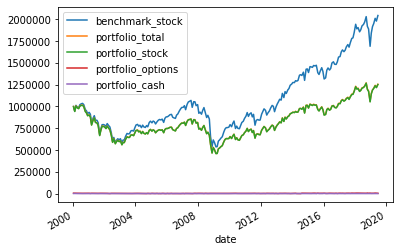

In [185]:
simulate_and_compare(
    build_goal(stock_alloc=0.995, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    1000000
)

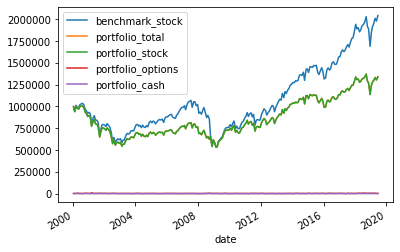

In [188]:
simulate_and_compare(
    build_goal(stock_alloc=0.995, otm_range=(0.2, 0.5), maturity_range=(60, 220)),
    1000000
)

# Dealing with the spread



One thing that's tough about these portfolios, is that the spreads are often _very_ large. One thing we cna try, is to see if somehow we could sell and buy at a better price, how it could look:


In [191]:
def get_option_buy_price(option_row):
  return option_row[OPTION_PRICES_AVG_COL]

def get_option_sell_price(option_row):
  return option_row[OPTION_PRICES_AVG_COL]

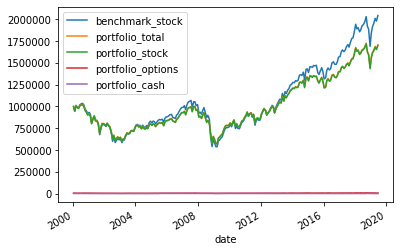

In [194]:
simulate_and_compare(
    build_goal(stock_alloc=0.995, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    1000000
)

This ends up looking much better. One thing we can also try -- What if we considered the Q ratio?

## Q Ratio

In [197]:
Q_RARTIO_FILE_PATH = 'tobins_q.csv'
Q_RATIO_DATE_COL = 'date'
Q_RATIO_VALUE_COL = 'value'

def load_q_ratios():
  q_ratios = pd.read_csv(Q_RARTIO_FILE_PATH)
  q_ratios[Q_RATIO_DATE_COL] = pd.to_datetime(q_ratios[Q_RATIO_DATE_COL])
  q_ratios = q_ratios.set_index(Q_RATIO_DATE_COL, drop=False)
  
  return q_ratios


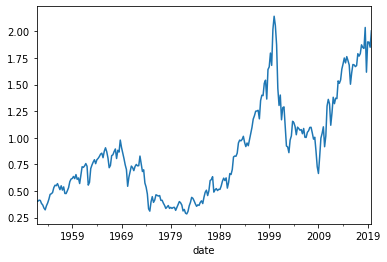

In [200]:
Q_RATIOS = load_q_ratios()
Q_RATIOS[Q_RATIO_VALUE_COL].plot()
plt.show()

In [203]:
def get_q_ratio_for_date(date):
    q_ratios_before_date = Q_RATIOS[Q_RATIOS[Q_RATIO_DATE_COL] < date]
    latest_q_ratio = q_ratios_before_date.last('3D').iloc[0]

    return latest_q_ratio[Q_RATIO_VALUE_COL]

In [206]:
get_q_ratio_for_date(datetime(2000, 1, 3))

2.14224612552741

Now let's update trade_for_date, to consider this

In [216]:
from copy import copy

def trade_for_date(portfolio_row, goal):
  date = portfolio_row[PORTFOLIO_DATE]
  q_ratio = get_q_ratio_for_date(date)
  if q_ratio < 1.2:
      goal = copy(goal)
      goal[GOAL_STOCK_ALLOC] = 0.999
  
  best_option_row = find_best_option_row_to_buy(date, goal[GOAL_OTM_RANGE], goal[GOAL_MATURITY_RANGE])
  new_portfolio_row = buy_at_allocation(
    sell_over_allocation(portfolio_row, goal, best_option_row),
    goal,
    best_option_row)
  
  return new_portfolio_row

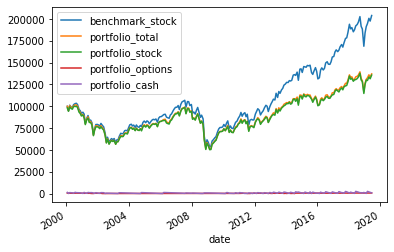

In [217]:
simulate_and_compare(
    build_goal(stock_alloc=0.995, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    100000
)

# Looking at SPY

What if we tried SPY and American options, instead of SPX and european options?

First, let's reset

In [226]:
STOCK_PRICES = load_spy_prices()
STOCK_PRICES

,Date,Price,Open,High,Low,Vol.,Change %,Avg
0,2010-06-30,103.22,103.92,104.88,102.88,284.10M,-0.95%,103.880
1,2010-06-29,104.21,106.02,107.51,103.55,373.76M,-3.09%,105.530
2,2010-06-28,107.53,108.03,108.32,107.14,169.33M,-0.32%,107.730
3,2010-06-25,107.87,107.74,108.42,106.77,238.73M,0.42%,107.595
4,2010-06-24,107.42,108.69,108.83,107.14,268.69M,-1.66%,107.985
...,...,...,...,...,...,...,...,...
2634,2000-01-07,145.75,140.31,145.75,140.06,8.07M,5.81%,142.905
2635,2000-01-06,137.75,139.62,141.50,137.75,6.23M,-1.61%,139.625
2636,2000-01-05,140.00,139.94,141.53,137.25,12.18M,0.18%,139.390
2637,2000-01-04,139.75,143.53,144.06,139.64,8.09M,-3.91%,141.850


## SPY ETF

In [225]:
SPY_PRICES_FILE_PATH = 'spy_etf_prices.csv'

def load_spy_prices():
  spy_prices = pd.read_csv(SPY_PRICES_FILE_PATH)
  spy_prices[STOCK_PRICES_DATE_COL] = pd.to_datetime(spy_prices[STOCK_PRICES_DATE_COL])
  spy_prices[STOCK_PRICES_AVG_COL] = ((spy_prices[STOCK_PRICES_HIGH_COL] + spy_prices[STOCK_PRICES_LOW_COL]) / 2)
  
  return spy_prices

In [228]:
OPTION_PRICES = load_spy_option_prices()
OPTION_PRICES

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,vega,theta,optionid,forward_price,index_flag,issuer,exercise_style,maturity,spread,avg
0,108105,2000-01-03,2000-03-18,19991229.0,P,1410.0,36.750,38.750,0,1,...,235.99500,-119.41110,10120210,1470.521157,1,CBOE S&P 500 INDEX,E,75,2.0,37.750
1,108105,2000-01-03,2000-01-22,19991223.0,P,1505.0,55.250,57.250,0,50,...,100.89450,-172.62950,10000760,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,56.250
2,108105,2000-01-03,2000-06-17,20000103.0,P,1350.0,40.750,42.750,290,14570,...,311.57080,-66.86736,10016917,1490.761534,1,CBOE S&P 500 INDEX,E,166,2.0,41.750
3,108105,2000-01-03,2000-01-22,20000103.0,P,1500.0,51.625,53.625,57,505,...,105.71350,-186.79210,10149633,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,52.625
4,108105,2000-01-03,2000-01-22,NaN,P,1540.0,84.875,86.875,0,0,...,68.56206,-96.37443,10056576,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,85.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462523,108105,2019-06-28,2020-06-30,NaN,P,3800.0,824.100,848.000,0,0,...,NaN,NaN,129500433,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,836.050
8462524,108105,2019-06-28,2020-06-30,NaN,P,3900.0,921.200,945.200,0,0,...,NaN,NaN,129500434,2942.162769,1,CBOE S&P 500 INDEX,E,368,24.0,933.200
8462525,108105,2019-06-28,2020-06-30,NaN,P,4000.0,1018.700,1042.500,0,0,...,NaN,NaN,129500435,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.8,1030.600
8462526,108105,2019-06-28,2020-06-30,NaN,P,4100.0,1116.100,1140.000,0,0,...,NaN,NaN,129500436,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,1128.050


## SPY Options

In [227]:
SPY_OPTION_PRICES_FILE_PATH = 'spy_option_prices.csv'

def load_spy_option_prices():
  option_prices = pd.read_csv(SPX_OPTION_PRICES_FILE_PATH);
  option_prices[OPTION_PRICES_DATE_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_DATE_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_EXPIRATION_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_EXPIRATION_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_STRIKE_COL] = option_prices[OPTION_PRICES_STRIKE_COL].div(1000)
  option_prices[OPTION_PRICES_MATURITY_COL] = (
    option_prices[OPTION_PRICES_EXPIRATION_COL] - 
    option_prices[OPTION_PRICES_DATE_COL]
  ).dt.days
  option_prices[OPTION_PRICES_SPREAD_COL] = (
    option_prices[OPTION_PRICES_OFFER_COL] - 
    option_prices[OPTION_PRICES_BID_COL]
  )
  option_prices[OPTION_PRICES_AVG_COL] = (
    (
      option_prices[OPTION_PRICES_OFFER_COL] +
      option_prices[OPTION_PRICES_BID_COL]
    ) / 2
  )

  return option_prices

In [230]:
simulate_and_compare(
    build_goal(stock_alloc=0.995, otm_range=(0.2, 0.5), maturity_range=(60, 230)),
    1000000
)

SystemExit: wasn't able to find an option for 2000-01-21 00:00:00